# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-1"}
    download(args)
    extract("data/Model_I.tgz", "data/")
    extract("data/Model_I_test.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV
From (redirected): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV&confirm=t&uuid=2373c7c1-b59b-4826-b5cf-141b69670af8
To: /opt/repo/GSoC-23/data/Model_I.tgz
100%|█████████████████████████████████████████████████████| 1.99G/1.99G [00:20<00:00, 95.9MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1
From (redirected): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1&confirm=t&uuid=ca98daac-004d-443d-9262-77fa6a8902c3
To: /opt/repo/GSoC-23/data/Model_I_test.tgz
100%|███████████████████████████████████████████████████████| 340M/340M [00:07<00:00, 44.0MB/s]


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
class AxionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_name = "axion"
        self.class_folder = os.path.join(self.root_dir, self.class_name)
        self.file_list = [f for f in os.listdir(self.class_folder) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.file_list[idx]
        file_path = os.path.join(self.class_folder, file_name)
        data = np.load(file_path, allow_pickle=True)
        image = data[0]
        weight = data[1]
        image = 255 * (image / image.max())
        image = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image.float(), weight.astype('float32')
    

trainset = AxionDataset(
    root_dir='data/Model_I',
    transform = train_transforms
)

testset = AxionDataset(
    root_dir='data/Model_I_test',
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [5]:
lr = 0.0001
epochs = 10
gamma = 0.7
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [6]:
from models import C8SCNN

model = C8SCNN(1).to(device)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

# Training


In [ ]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0, 0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label).float()
        tr_loss_epoch.append(loss.item())
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total += len(label)

        epoch_loss += loss / len(train_loader)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct / total * 100)
    epoch_accuracy = (correct / total) * 100
    correct, total = 0, 0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)

            epoch_val_loss += val_loss / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct / total * 100)
    epoch_val_accuracy = (correct / total) * 100

    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(model)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
torch.save(best_model.state_dict(), "equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

 90%|████████████████████████████████████████████████████▏     | 71/79 [00:19<00:02,  3.62it/s]

# Plotting Loss and Accuracy


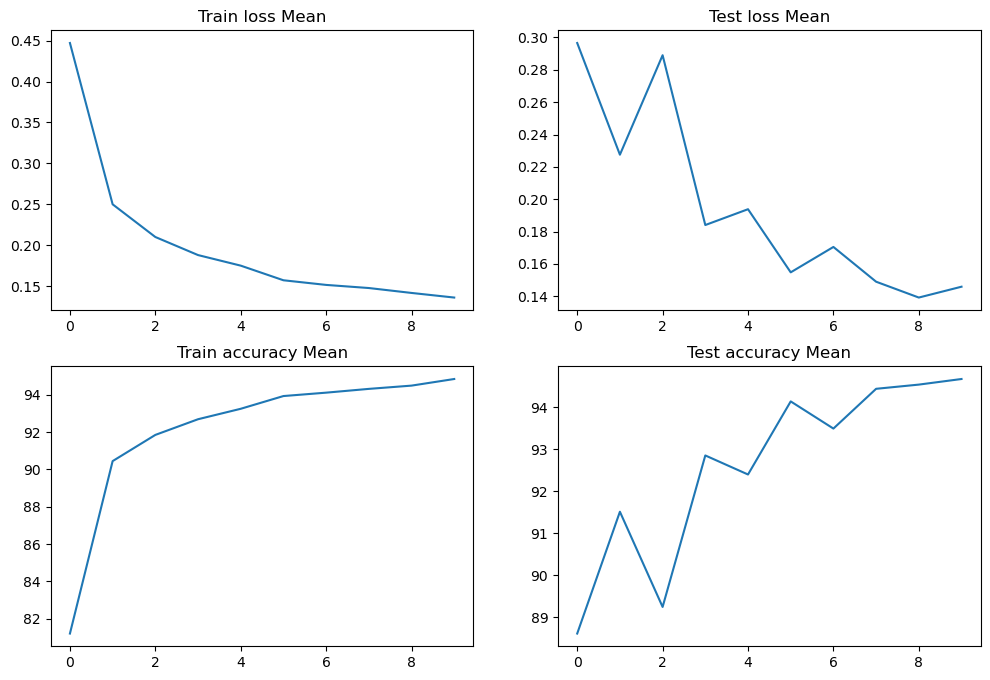

In [8]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title("Train accuracy Mean")
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title("Test accuracy Mean")
plt.plot(all_test_accuracy)

# Loading Best Model


In [9]:
model = C8SCNN(3).to(device)
model.load_state_dict(torch.load("equi_nn.pth"), strict=False)

_IncompatibleKeys(missing_keys=['block1.1.filter', 'block2.0.filter', 'block3.0.filter', 'block4.0.filter', 'block5.0.filter', 'block6.0.filter'], unexpected_keys=[])

# Testing


In [7]:
import torch.nn.functional as F
with torch.no_grad():
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)
        
        # Calculate metrics
        rmse = torch.sqrt(F.mse_loss(_y, y))
        mse = F.mse_loss(_y, y)
        mae = F.l1_loss(_y, y)
        
        rmse_list.append(rmse.item())
        mse_list.append(mse.item())
        mae_list.append(mae.item())

# Calculate overall metrics
avg_rmse = np.mean(rmse_list)
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)

print("Average RMSE:", avg_rmse)
print("Average MSE:", avg_mse)
print("Average MAE:", avg_mae)

  0%|                                                                   | 0/79 [00:01<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type